<a href="https://colab.research.google.com/github/shreytanwar/Deep-Belief-Network-and-Logistic-Regression-For-Software-Fault-Prediction/blob/master/recreateDeeper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import tensorflow as tf
from sklearn.metrics import log_loss, accuracy_score
import numpy as np
import pandas as pd
# from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import Grid

In [ ]:
df= pd.read_csv('/content/drive/My Drive/dataset/bugzilla.csv')

In [ ]:
def normalize(x):
  x = x.astype(float)
  min = np.min(x)
  max = np.max(x)
  return (x - min)/(max-min)

In [ ]:
def view_values(X, y, example):
    label = y.loc[example]
    image = X.loc[example,:].values.reshape([-1,1])
    print(image)

In [ ]:
print("Shape of dataframe: ", df.shape)   #train

Shape of dataframe:  (4620, 17)


In [ ]:
df.describe()

,transactionid,ns,nm,nf,entropy,la,ld,lt,fix,ndev,pd,npt,exp,rexp,sexp,bug
count,4620.000000,4620.000000,4620.000000,4620.000000,4620.000000,4620.000000,4620.000000,4620.000000,4620.000000,4620.000000,4620.000000,4620.000000,4620.000000,4620.000000,4620.000000,4620.000000
mean,5819.241558,1.169913,1.220346,2.287662,0.229153,0.071410,3.113758,591.379777,0.859957,16.424892,173.927922,0.952656,342.570563,253.033361,230.821429,0.367100
std,4223.181222,0.424315,0.569805,4.275243,0.371861,0.491756,198.624600,547.895977,0.347070,10.743430,646.256119,0.137676,392.273355,268.292945,269.729476,0.482066
min,3.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.037037,1.000000,1.000000,1.000000,0.000000
25%,2211.750000,1.000000,1.000000,1.000000,0.000000,0.003093,0.001295,210.000000,1.000000,7.000000,3.000000,1.000000,58.000000,52.000000,35.000000,0.000000
50%,5193.500000,1.000000,1.000000,1.000000,0.000000,0.009909,0.005109,455.000000,1.000000,16.000000,20.000000,1.000000,196.000000,156.000000,129.500000,0.000000
75%,8804.250000,1.000000,1.000000,2.000000,0.551098,0.035356,0.017502,799.250000,1.000000,24.000000,119.000000,1.000000,489.000000,352.000000,341.250000,1.000000
max,20938.000000,4.000000,8.000000,63.000000,1.000000,21.000000,13495.000000,2751.000000,1.000000,47.000000,15836.000000,1.000000,1815.000000,1042.750000,1741.000000,1.000000


In [ ]:
df.head()

,transactionid,commitdate,ns,nm,nf,entropy,la,ld,lt,fix,ndev,pd,npt,exp,rexp,sexp,bug
0,3,2001/12/12 17:41,1,1,3,0.579380,0.093620,0.000000,480.666667,1,14,596,0.666667,143,133.50,129,1
1,7,1999/10/12 12:57,1,1,1,0.000000,0.000000,0.000000,398.000000,1,1,0,1.000000,140,140.00,137,1
2,8,2002/5/15 16:55,3,3,52,0.739279,0.183477,0.208913,283.519231,0,23,15836,0.750000,984,818.65,978,0
3,9,2002/1/21 15:37,1,1,8,0.685328,0.016039,0.012880,514.375000,1,21,1281,1.000000,579,479.25,550,0
4,10,2001/12/19 16:44,2,2,38,0.769776,0.091829,0.072746,366.815789,1,21,6565,0.763158,413,313.25,405,0


In [ ]:
#more visual way to see the values int the column

def view_digit(X, y, example):
    label = y.loc[example]
    image = X.loc[example,:].values.reshape([14,1])
    plt.title('Example: %d  Label: %d' % (example, label))
    plt.imshow(image, cmap=plt.get_cmap('gray'))
    plt.show()

### RBM


In [ ]:
# Define RBM class
class RBM(object):
    
    def __init__(self, input_size, output_size, 
                 learning_rate, epochs, batchsize):
        # Define hyperparameters
        self._input_size = input_size
        self._output_size = output_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batchsize = batchsize
        
        # Initialize weights and biases using zero matrices
        self.w = np.zeros([input_size, output_size], dtype=np.float32)
        self.hb = np.zeros([output_size], dtype=np.float32)
        self.vb = np.zeros([input_size], dtype=np.float32)
    # forward pass, where h is the hidden layer and v is the visible layer
    def prob_h_given_v(self, visible, w, hb):
        return tf.nn.sigmoid(tf.matmul(visible, w) + hb)
    # backward pass
    def prob_v_given_h(self, hidden, w, vb):
        return tf.nn.sigmoid(tf.matmul(hidden, tf.transpose(w)) + vb)
    # sampling function
    def sample_prob(self, probs):
        return tf.nn.relu(tf.sign(probs - tf.random_uniform(tf.shape(probs))))

    def train(self, X):
        _w = tf.placeholder(tf.float32, [self._input_size, self._output_size])
        _hb = tf.placeholder(tf.float32, [self._output_size])
        _vb = tf.placeholder(tf.float32, [self._input_size])
        
        prv_w = np.zeros([self._input_size, self._output_size], dtype=np.float32)
        prv_hb = np.zeros([self._output_size], dtype=np.float32)
        prv_vb = np.zeros([self._input_size], dtype=np.float32)
        
        cur_w = np.zeros([self._input_size, self._output_size], dtype=np.float32)
        cur_hb = np.zeros([self._output_size], dtype=np.float32)
        cur_vb = np.zeros([self._input_size], dtype=np.float32)
        
        v0 = tf.placeholder(tf.float32, [None, self._input_size])
        h0 = self.sample_prob(self.prob_h_given_v(v0, _w, _hb))
        v1 = self.sample_prob(self.prob_v_given_h(h0, _w, _vb))
        h1 = self.prob_h_given_v(v1, _w, _hb)
        #To update the weights, we perform constrastive divergence.
        positive_grad = tf.matmul(tf.transpose(v0), h0)
        negative_grad = tf.matmul(tf.transpose(v1), h1)
        
        update_w = _w + self.learning_rate * (positive_grad - negative_grad) / tf.to_float(tf.shape(v0)[0])
        update_vb = _vb +  self.learning_rate * tf.reduce_mean(v0 - v1, 0)
        update_hb = _hb +  self.learning_rate * tf.reduce_mean(h0 - h1, 0)
        # We also define the error as the MSE
        err = tf.reduce_mean(tf.square(v0 - v1))
        
        error_list = []
        '''Once we call sess.run, we can feed in batches of data to begin the training. 
           During the training, forward and backward passes will be made, and the RBM 
           will update weights based on how the generated data compares to the original input. 
           We will print the reconstruction error from each epoch'''
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            
            for epoch in range(self.epochs):
                for start, end in zip(range(0, len(X),  self.batchsize),range(self.batchsize,len(X), self.batchsize)):
                    batch = X[start:end]
                    cur_w = sess.run(update_w, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_hb = sess.run(update_hb, feed_dict={v0: batch,  _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_vb = sess.run(update_vb, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    prv_w = cur_w
                    prv_hb = cur_hb
                    prv_vb = cur_vb
                error = sess.run(err, feed_dict={v0: X, _w: cur_w, _vb: cur_vb, _hb: cur_hb})
                print ('Epoch: %d' % epoch,'reconstruction error: %f' % error)
                error_list.append(error)
            self.w = prv_w
            self.hb = prv_hb
            self.vb = prv_vb
            return error_list
    #function to generate new images from the generative model that the RBM has learned
    def rbm_output(self, X):
        
        input_X = tf.constant(X)
        _w = tf.constant(self.w)
        _hb = tf.constant(self.hb)
        _vb = tf.constant(self.vb)
        out = tf.nn.sigmoid(tf.matmul(input_X, _w) + _hb)
        hiddenGen = self.sample_prob(self.prob_h_given_v(input_X, _w, _hb))
        visibleGen = self.sample_prob(self.prob_v_given_h(hiddenGen, _w, _vb))
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            return sess.run(out), sess.run(visibleGen), sess.run(hiddenGen)
    # function to show the feature detectors of the hidden layer    
    def show_features(self, shape, suptitle, count=-1):
        maxw = np.amax(self.w.T)
        minw = np.amin(self.w.T)
        count = self._output_size if count == -1 or count > self._output_size else count
        ncols = count if count < 14 else 14 
        nrows = count//ncols
        nrows = nrows if nrows > 2 else 3
        fig = plt.figure(figsize=(ncols, nrows), dpi=100)
        grid = Grid(fig, rect=111, nrows_ncols=(nrows, ncols), axes_pad=0.01)

        for i, ax in enumerate(grid):
            x = self.w.T[i] if i<self._input_size else np.zeros(shape)
            x = (x.reshape(1, -1) - minw)/maxw
            ax.imshow(x.reshape(*shape), cmap=mpl.cm.Greys)
            ax.set_axis_off()

        fig.text(0.5,1, suptitle, fontsize=20, horizontalalignment='center')
        fig.tight_layout()
        plt.show()
        return

## Training

In [ ]:
#Droping unnecessary String columns
df=df.drop(['commitdate','transactionid'], axis=1)


In [ ]:
#split df
train_X = df.iloc[:,:-1].apply(func=normalize, axis=0)
train_Y = df.iloc[:,-1]

In [ ]:
# df=df.drop(['transactionid'], axis=1)
print(df.head())
df.shape

   ns  nm  nf   entropy        la  ...       npt  exp    rexp  sexp  bug
0   1   1   3  0.579380  0.093620  ...  0.666667  143  133.50   129    1
1   1   1   1  0.000000  0.000000  ...  1.000000  140  140.00   137    1
2   3   3  52  0.739279  0.183477  ...  0.750000  984  818.65   978    0
3   1   1   8  0.685328  0.016039  ...  1.000000  579  479.25   550    0
4   2   2  38  0.769776  0.091829  ...  0.763158  413  313.25   405    0

[5 rows x 15 columns]


(4620, 15)

In [ ]:
inputX = df.iloc[:,:-1].apply(func=normalize, axis=0).values
inputY= df.iloc[:,-1].values
print(type(inputX))
inputX = inputX.astype(np.float32)

#List to hold RBMs
rbm_list = []

#define parameters of RBMs we will train
# 14-20-12-12-2

# def __init__(self, input_size, output_size,learning_rate, epochs, batchsize):
rbm_list.append(RBM(14, 20, 0.002, 200, 100))
rbm_list.append(RBM(20, 12, 0.002, 200, 100))
rbm_list.append(RBM(12, 12, 0.002, 200, 100))

<class 'numpy.ndarray'>


In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
outputList = []
error_list = []

#For each RBM in out list
for i in range(0, len(rbm_list)):
    print('RBM', i+1)
    #Train new RBM
    rbm = rbm_list[i]
    err = rbm.train(inputX)
    error_list.append(err)

    #Return output layer
    #sess.run(out), sess.run(visibleGen), sess.run(hiddenGen)
    outputX, reconstructedX, hiddenX = rbm.rbm_output(inputX)
    outputList.append(outputX)
    inputX= hiddenX

RBM 1
Instructions for updating:
Use `tf.cast` instead.
Epoch: 0 reconstruction error: 0.405610
Epoch: 1 reconstruction error: 0.372414
Epoch: 2 reconstruction error: 0.340579
Epoch: 3 reconstruction error: 0.313986
Epoch: 4 reconstruction error: 0.296913
Epoch: 5 reconstruction error: 0.277447
Epoch: 6 reconstruction error: 0.260589
Epoch: 7 reconstruction error: 0.251172
Epoch: 8 reconstruction error: 0.236274
Epoch: 9 reconstruction error: 0.226843
Epoch: 10 reconstruction error: 0.220158
Epoch: 11 reconstruction error: 0.211969
Epoch: 12 reconstruction error: 0.207240
Epoch: 13 reconstruction error: 0.198529
Epoch: 14 reconstruction error: 0.192598
Epoch: 15 reconstruction error: 0.187786
Epoch: 16 reconstruction error: 0.183598
Epoch: 17 reconstruction error: 0.179589
Epoch: 18 reconstruction error: 0.177002
Epoch: 19 reconstruction error: 0.172843
Epoch: 20 reconstruction error: 0.172136
Epoch: 21 reconstruction error: 0.168514
Epoch: 22 reconstruction error: 0.165323
Epoch: 23 r

RBM 1


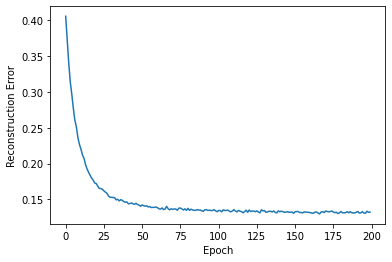

RBM 2


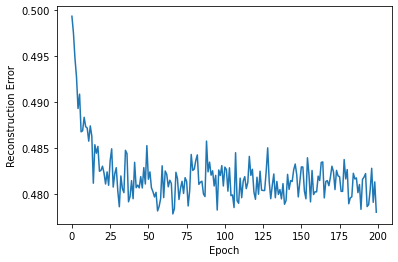

RBM 3


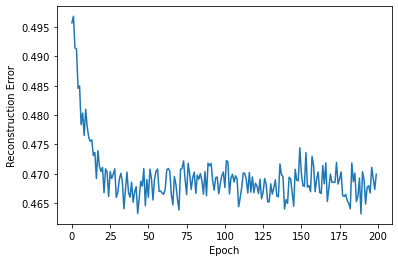

In [ ]:
i = 1
for err in error_list:
    print("RBM",i)
    pd.Series(err).plot(logy=False)
    plt.xlabel("Epoch")
    plt.ylabel("Reconstruction Error")
    plt.show()
    i += 1

In [ ]:
inputX = np.array(train_X)
inputX = inputX.astype(np.float32)
rbmOne = rbm_list[0]

In [ ]:

print('RBM 1')
outputX_rbmOne, reconstructedX_rbmOne, hiddenX_rbmOne = rbmOne.rbm_output(inputX)
reconstructedX_rbmOne = pd.DataFrame(data=reconstructedX_rbmOne, index=train_X.index)
for j in range(0,1):
    example = j
    print("Data generated by First RBM Layer")
    view_values(reconstructedX_rbmOne, train_Y, example)
    print("Original Data")
    view_values(train_X, train_Y, example)

RBM 1
Data generated by First RBM Layer
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]]
Original Data
[[0.        ]
 [0.        ]
 [0.03225806]
 [0.57938016]
 [0.00445809]
 [0.        ]
 [0.17472434]
 [1.        ]
 [0.2826087 ]
 [0.03763577]
 [0.65384615]
 [0.07828004]
 [0.12718982]
 [0.07356322]]


In [ ]:
reconstructedX_rbmOne.shape

(4620, 14)

### DBN

In [ ]:
class DBN(object):
    def __init__(self, original_input_size, input_size, output_size, 
                 learning_rate, epochs, batchsize, rbmOne, rbmTwo, rbmThree):
        # Define hyperparameters
        self._original_input_size = original_input_size
        self._input_size = input_size
        self._output_size = output_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batchsize = batchsize
        self.rbmOne = rbmOne
        self.rbmTwo = rbmTwo
        self.rbmThree = rbmThree
    
        self.w = np.zeros([input_size, output_size], "float")
        self.hb = np.zeros([output_size], "float")
        self.vb = np.zeros([input_size], "float")
    
    def prob_h_given_v(self, visible, w, hb):
        return tf.nn.sigmoid(tf.matmul(visible, w) + hb)

    def prob_v_given_h(self, hidden, w, vb):
        return tf.nn.sigmoid(tf.matmul(hidden, tf.transpose(w)) + vb)
    
    def sample_prob(self, probs):
        return tf.nn.relu(tf.sign(probs - tf.random_uniform(tf.shape(probs))))

    '''Each of the three RBMs we have trained already has its own weights matrix, 
    hidden bias vector, and visible bias vector. During the training of the fourth RBM as 
    part of the DBN, we will not adjust the weights matrix, hidden bias vector, and 
    visible bias vector of those first three RBMs. Rather, we will use the first three 
    RBMs as fixed components of the DBN. We will call upon the first three RBMs just to 
    do the forward and backward passes (and use samples of the data these three generate).

    During the training of the fourth RBM in the DBN, we will only adjust weights and 
    biases of the fourth RBM. In other words, the fourth RBM in the DBN takes the output 
    of the first three RBMs as given and performs forward and backward passes to learn 
    a generative model that minimizes the reconstruction error between its generated 
    images and the original images'''
    def train(self, X):
        _w = tf.placeholder("float", [self._input_size, self._output_size])
        _hb = tf.placeholder("float", [self._output_size])
        _vb = tf.placeholder("float", [self._input_size])
        
        prv_w = np.zeros([self._input_size, self._output_size], "float")
        prv_hb = np.zeros([self._output_size], "float")
        prv_vb = np.zeros([self._input_size], "float")
        
        cur_w = np.zeros([self._input_size, self._output_size], "float")
        cur_hb = np.zeros([self._output_size], "float")
        cur_vb = np.zeros([self._input_size], "float")
        
        v0 = tf.placeholder("float", [None, self._original_input_size])

        forwardOne = tf.nn.relu(tf.sign(tf.nn.sigmoid(tf.matmul(v0, self.rbmOne.w) + self.rbmOne.hb) - tf.random_uniform(tf.shape(tf.nn.sigmoid(tf.matmul(v0, self.rbmOne.w) + self.rbmOne.hb)))))
        forwardTwo = tf.nn.relu(tf.sign(tf.nn.sigmoid(tf.matmul(forwardOne, self.rbmTwo.w) + self.rbmTwo.hb) - tf.random_uniform(tf.shape(tf.nn.sigmoid(tf.matmul(forwardOne, self.rbmTwo.w) + self.rbmTwo.hb)))))
        forward = tf.nn.relu(tf.sign(tf.nn.sigmoid(tf.matmul(forwardTwo, self.rbmThree.w) + self.rbmThree.hb) - tf.random_uniform(tf.shape(tf.nn.sigmoid(tf.matmul( forwardTwo, self.rbmThree.w) + self.rbmThree.hb)))))
        h0 = self.sample_prob(self.prob_h_given_v(forward, _w, _hb))
        v1 = self.sample_prob(self.prob_v_given_h(h0, _w, _vb))
        h1 = self.prob_h_given_v(v1, _w, _hb)
        
        positive_grad = tf.matmul(tf.transpose(forward), h0)
        negative_grad = tf.matmul(tf.transpose(v1), h1)
        
        update_w = _w + self.learning_rate * (positive_grad - negative_grad) / tf.to_float(tf.shape(forward)[0])
        update_vb = _vb +  self.learning_rate * tf.reduce_mean(forward - v1, 0)
        update_hb = _hb +  self.learning_rate * tf.reduce_mean(h0 - h1, 0)
        
        backwardOne = tf.nn.relu(tf.sign(tf.nn.sigmoid(tf.matmul(v1, self.rbmThree.w.T) + self.rbmThree.vb) - tf.random_uniform(tf.shape(tf.nn.sigmoid(tf.matmul(v1, self.rbmThree.w.T) + self.rbmThree.vb)))))
        backwardTwo = tf.nn.relu(tf.sign(tf.nn.sigmoid(tf.matmul(backwardOne, self.rbmTwo.w.T) + self.rbmTwo.vb) - tf.random_uniform(tf.shape(tf.nn.sigmoid(tf.matmul(backwardOne, self.rbmTwo.w.T) + self.rbmTwo.vb)))))
        backward = tf.nn.relu(tf.sign(tf.nn.sigmoid(tf.matmul(backwardTwo, self.rbmOne.w.T) + self.rbmOne.vb) - tf.random_uniform(tf.shape(tf.nn.sigmoid(tf.matmul(backwardTwo, self.rbmOne.w.T) + self.rbmOne.vb)))))
        
        err = tf.reduce_mean(tf.square(v0 - backward))
        error_list = []
        
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())

            for epoch in range(self.epochs):
                for start, end in zip(range(0, len(X), self.batchsize), range(self.batchsize,len(X), self.batchsize)):
                    batch = X[start:end]
                    cur_w = sess.run(update_w, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_hb = sess.run(update_hb, feed_dict={v0: batch, _w:  prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_vb = sess.run(update_vb, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    prv_w = cur_w
                    prv_hb = cur_hb
                    prv_vb = cur_vb
                error = sess.run(err, feed_dict={v0: X, _w: cur_w, _vb: cur_vb, _hb: cur_hb})
                print ('Epoch: %d' % (epoch+1),'reconstruction error: %f' % error)
                error_list.append(error)
            self.w = prv_w
            self.hb = prv_hb
            self.vb = prv_vb
            return error_list
        
    def dbn_output(self, X):

        input_X = tf.constant(X)
        forwardOne = tf.nn.sigmoid(tf.matmul(input_X, self.rbmOne.w) + self.rbmOne.hb)
        forwardTwo = tf.nn.sigmoid(tf.matmul(forwardOne, self.rbmTwo.w) + self.rbmTwo.hb)
        forward = tf.nn.sigmoid(tf.matmul(forwardTwo, self.rbmThree.w) + self.rbmThree.hb)

        _w = tf.constant(self.w)
        _hb = tf.constant(self.hb)
        _vb = tf.constant(self.vb)

        out = tf.nn.sigmoid(tf.matmul(forward, _w) + _hb)
        hiddenGen = self.sample_prob(self.prob_h_given_v(forward, _w, _hb))
        visibleGen = self.sample_prob(self.prob_v_given_h(hiddenGen, _w, _vb))

        backwardTwo = tf.nn.sigmoid(tf.matmul(visibleGen, self.rbmThree.w.T) + self.rbmThree.vb)
        backwardOne = tf.nn.sigmoid(tf.matmul(backwardTwo, self.rbmTwo.w.T) + self.rbmTwo.vb)
        backward = tf.nn.sigmoid(tf.matmul(backwardOne, self.rbmOne.w.T) + self.rbmOne.vb)

        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            return sess.run(out), sess.run(backward)

    def show_features(self, shape, suptitle, count=-1):
        maxw = np.amax(self.w.T)
        minw = np.amin(self.w.T)
        count = self._output_size if count == -1 or count > self._output_size else count
        ncols = count if count < 14 else 14 
        nrows = count//ncols
        nrows = nrows if nrows > 2 else 3
        fig = plt.figure(figsize=(ncols, nrows), dpi=100)
        grid = Grid(fig, rect=111, nrows_ncols=(nrows, ncols), axes_pad=0.01)

        for i, ax in enumerate(grid):
            x = self.w.T[i] if i<self._input_size else np.zeros(shape)
            x = (x.reshape(1, -1) - minw)/maxw
            ax.imshow(x.reshape(*shape), cmap=mpl.cm.Greys)
            ax.set_axis_off()

        fig.text(0.5,1, suptitle, fontsize=20, horizontalalignment='center')
        fig.tight_layout()
        plt.show()
        return

def __init__(self, original_input_size, input_size, output_size, 
                 learning_rate, epochs, batchsize, rbmOne, rbmTwo, rbmThree):

In [ ]:
dbn = DBN(14, 12, 12, 0.02, 50, 100, rbm_list[0], rbm_list[1], rbm_list[2])

In [ ]:
inputX = np.array(inputX)
error_list = []
error_list = dbn.train(inputX)

Epoch: 1 reconstruction error: 0.133390
Epoch: 2 reconstruction error: 0.133506
Epoch: 3 reconstruction error: 0.133857
Epoch: 4 reconstruction error: 0.133670
Epoch: 5 reconstruction error: 0.133016
Epoch: 6 reconstruction error: 0.134164
Epoch: 7 reconstruction error: 0.134729
Epoch: 8 reconstruction error: 0.133281
Epoch: 9 reconstruction error: 0.132892
Epoch: 10 reconstruction error: 0.134146
Epoch: 11 reconstruction error: 0.134501
Epoch: 12 reconstruction error: 0.132174
Epoch: 13 reconstruction error: 0.130029
Epoch: 14 reconstruction error: 0.133361
Epoch: 15 reconstruction error: 0.132113
Epoch: 16 reconstruction error: 0.132682
Epoch: 17 reconstruction error: 0.132792
Epoch: 18 reconstruction error: 0.134617
Epoch: 19 reconstruction error: 0.133331
Epoch: 20 reconstruction error: 0.132751
Epoch: 21 reconstruction error: 0.134368
Epoch: 22 reconstruction error: 0.132014
Epoch: 23 reconstruction error: 0.132406
Epoch: 24 reconstruction error: 0.133188
Epoch: 25 reconstruction 

DBN


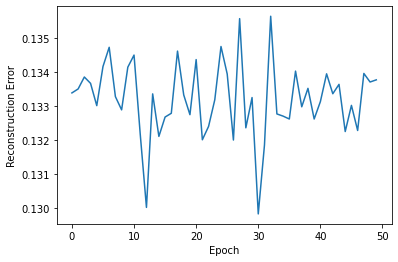

In [ ]:
print("DBN")
pd.Series(error_list).plot(logy=False)
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Error")
plt.show()

In [ ]:
train_X.shape
train_Y.head

<bound method NDFrame.head of 0       1
1       1
2       0
3       0
4       0
       ..
4615    1
4616    1
4617    0
4618    0
4619    0
Name: bug, Length: 4620, dtype: int64>

TESTING



In [ ]:
train_X.shape
# train_Y.shape

(4620, 14)

In [ ]:
print('DBN 1')
outputX_dbn, reconstructedX_dbn = dbn.dbn_output(inputX)

DBN 1


###**Classifier**(Logistic)


Used reconstructedX as the Input for the Classifer

In [ ]:
Y_Train = train_Y.iloc[:4000].values
Y_Train.shape

(4000,)

Logistic Regression

In [ ]:
def sigmoid(x):
    return 1.0/(1.0 + np.exp(-x))

def hypothesis(X, theta) :
    """ 
    X-entire array(m,n+1)
    n+1^ 1 dummy feature Xo

    theta- np.array(n+1,1)
    """
    return sigmoid(np.dot(X, theta))

def error(X,y,theta):
    """
    params:
    X:(m,n+1)
    y:(m,1)
    theta:(n+1,1)

    return:scale_value=loss
    """
    hi = hypothesis(X,theta)
    error= -1* np.mean ( y * np.log(hi) + ( ( 1 - y ) * (np.log( 1 - hi )) ) )

    return error

In [ ]:
def gradient(X,y,theta):
    """
    params:
    X:(m,n+1)
    y:(m,1)

    theta:(n+1,1)
     
    return:gradient_vector: (n+1,1)
    """
    hi = hypothesis(X,theta)

    grad = np.dot(X.T,(y-hi))
    m=X.shape[0]

    return grad/m

def gradient_descent(X,y,lr=0.02,max_itr=500):
    
    n=X.shape[1] 
    theta = np.zeros((n,1))
    
    error_list= []
    
    for i in range(max_itr):
        err = error(X,y,theta)
        error_list.append(err)

        grad = gradient(X,y,theta)
        #update theta
        theta = theta + lr * grad
    return (theta, error_list)

In [ ]:
ones = np.ones((outputX_dbn.shape[0],1))
X_New_Train = np.hstack((ones,outputX_dbn))
X_New_Train = X_New_Train[:4000,:]
Y_Train= Y_Train.reshape((-1,1))

In [ ]:
Y_Train.shape

(4000, 1)

In [ ]:
theta, error_list = gradient_descent(X_New_Train, Y_Train)

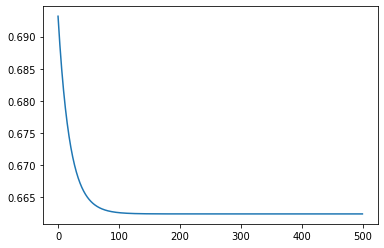

In [ ]:
plt.plot(error_list)

In [ ]:
theta.shape

(13, 1)

In [ ]:
def predict(X,theta):
    h = hypothesis(X, theta)
    output = np.zeros(h.shape)
    output[h>=0.5] = 1
    output = output.astype('int')
    return output

XT_preds = predict(X_New_Train,theta)

In [ ]:
def accuracy(actual, preds):

    actual = actual.astype('int')
    actual = actual.reshape((-1,1))

    acc= np.sum(actual==preds)/actual.shape[0]

    return acc*100

Accuracy

In [41]:
train_acc= accuracy(Y_Train,XT_preds)
print(train_acc)

62.324999999999996
